In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg
!pip install venn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co

import warnings
warnings.filterwarnings("ignore")

In [3]:
import importlib

## Preprocessing
### Read data

In [4]:
data_path = "../../data/MOBA_scRNAseq"
data_S3 = sc.read_10x_h5(data_path + "/outs_S3/filtered_feature_bc_matrix.h5")
data_S2 = sc.read_10x_h5(data_path + "/outs_S2/filtered_feature_bc_matrix.h5")
data_S3.obs["Sample"] = "S3"
data_S2.obs["Sample"] = "S2"

### Aggregate probes through max-pooling

In [5]:
data_maxpool_S3 = up.prep_probe_BacSC_data(data_S3, agg_fn=np.max)
sc.pp.calculate_qc_metrics(data_maxpool_S3, var_type="genes", percent_top=None, log1p=True, inplace=True)
data_maxpool_S3

Aggregating feature 100/5572
Aggregating feature 200/5572
Aggregating feature 300/5572
Aggregating feature 400/5572
Aggregating feature 500/5572
Aggregating feature 600/5572
Aggregating feature 700/5572
Aggregating feature 800/5572
Aggregating feature 900/5572
Aggregating feature 1000/5572
Aggregating feature 1100/5572
Aggregating feature 1200/5572
Aggregating feature 1300/5572
Aggregating feature 1400/5572
Aggregating feature 1500/5572
Aggregating feature 1600/5572
Aggregating feature 1700/5572
Aggregating feature 1800/5572
Aggregating feature 1900/5572
Aggregating feature 2000/5572
Aggregating feature 2100/5572
Aggregating feature 2200/5572
Aggregating feature 2300/5572
Aggregating feature 2400/5572
Aggregating feature 2500/5572
Aggregating feature 2600/5572
Aggregating feature 2700/5572
Aggregating feature 2800/5572
Aggregating feature 2900/5572
Aggregating feature 3000/5572
Aggregating feature 3100/5572
Aggregating feature 3200/5572
Aggregating feature 3300/5572
Aggregating feature

AnnData object with n_obs × n_vars = 1652 × 5572
    obs: 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [6]:
data_maxpool_S2 = up.prep_probe_BacSC_data(data_S2, agg_fn=np.max)
sc.pp.calculate_qc_metrics(data_maxpool_S2, var_type="genes", percent_top=None, log1p=True, inplace=True)
data_maxpool_S2

Aggregating feature 100/5572
Aggregating feature 200/5572
Aggregating feature 300/5572
Aggregating feature 400/5572
Aggregating feature 500/5572
Aggregating feature 600/5572
Aggregating feature 700/5572
Aggregating feature 800/5572
Aggregating feature 900/5572
Aggregating feature 1000/5572
Aggregating feature 1100/5572
Aggregating feature 1200/5572
Aggregating feature 1300/5572
Aggregating feature 1400/5572
Aggregating feature 1500/5572
Aggregating feature 1600/5572
Aggregating feature 1700/5572
Aggregating feature 1800/5572
Aggregating feature 1900/5572
Aggregating feature 2000/5572
Aggregating feature 2100/5572
Aggregating feature 2200/5572
Aggregating feature 2300/5572
Aggregating feature 2400/5572
Aggregating feature 2500/5572
Aggregating feature 2600/5572
Aggregating feature 2700/5572
Aggregating feature 2800/5572
Aggregating feature 2900/5572
Aggregating feature 3000/5572
Aggregating feature 3100/5572
Aggregating feature 3200/5572
Aggregating feature 3300/5572
Aggregating feature

AnnData object with n_obs × n_vars = 1326 × 5572
    obs: 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [7]:
data_all = ad.concat([data_S2, data_S3], axis=0, keys=["S2", "S3"], index_unique="_")
print(data_all)
data_maxpool = ad.concat([data_maxpool_S2, data_maxpool_S3], axis=0, keys=["S2", "S3"], index_unique="_")
sc.pp.calculate_qc_metrics(data_maxpool, var_type="genes", percent_top=None, log1p=True, inplace=True)

print(data_maxpool)

AnnData object with n_obs × n_vars = 2978 × 21982
    obs: 'Sample'
AnnData object with n_obs × n_vars = 2978 × 5572
    obs: 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'


In [8]:
print(f"Zero inflation of probe-wise data: {((np.prod(data_all.X.shape) - data_all.X.getnnz()) / np.prod(data_all.X.shape)).round(3)}")
print(f"Zero inflation of aggregated data: {((np.prod(data_maxpool.X.shape) - data_maxpool.X.getnnz()) / np.prod(data_maxpool.X.shape)).round(3)}")


Zero inflation of probe-wise data: 0.941
Zero inflation of aggregated data: 0.842


### Filter cells

--> filter based on mean absolute standard deviation

In [14]:
importlib.reload(ut)
data_gene = ut.filter_outliers(data_maxpool, nmads=5, min_cells=2)
print(data_maxpool.obs.outlier.value_counts())
print(f"Total number of cells: {data_maxpool.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

False    2840
True      138
Name: outlier, dtype: int64
Total number of cells: 2978
Number of cells after filtering: 2840


AnnData object with n_obs × n_vars = 2840 × 5557
    obs: 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

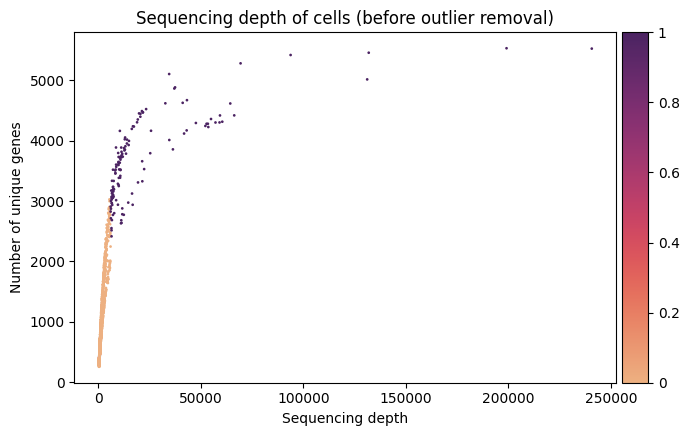

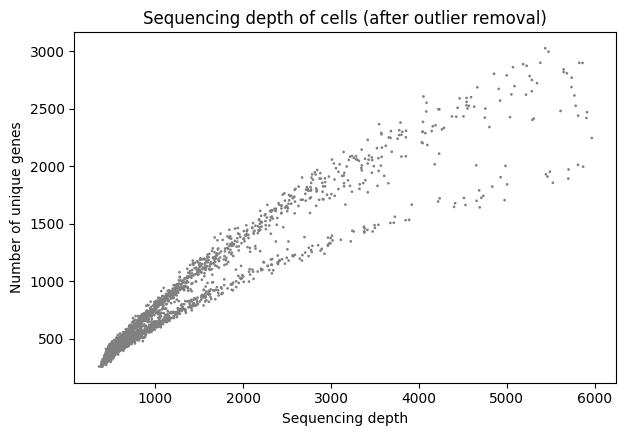

In [15]:
g = sc.pl.scatter(data_maxpool, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="flare", title="Sequencing depth of cells (before outlier removal)")
g.set(xlabel = "Sequencing depth")
g.set(ylabel="Number of unique genes")
plt.tight_layout()
plt.show()

sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15)
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

## Variance stabilization

Plotting the mean-variance ratio of genes, we see that the data is clearly overdispersed. Therefore, we will use negative binomial count splitting

In [16]:
data_gene.layers["counts"] = data_gene.X.copy()

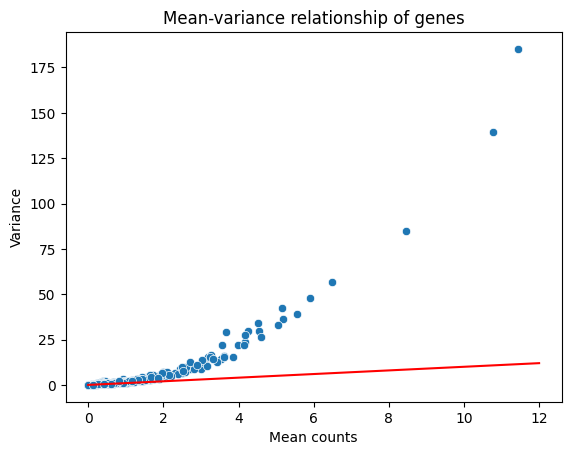

In [17]:
data_gene.var["var_counts"] = np.asarray(np.var(data_gene.X.toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.X.toarray(), axis=0)).squeeze()
sns.scatterplot(data=data_gene.var, x="mean_counts", y="var_counts")
plt.plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
plt.title("Mean-variance relationship of genes")
plt.xlabel("Mean counts")
plt.ylabel("Variance")
plt.show()

In [18]:
mv_corr_lin = np.corrcoef(data_gene.var["mean_counts"], data_gene.var["var_counts"])[0,1]
mv_corr_sq = np.corrcoef(data_gene.var["mean_counts"]**2, data_gene.var["var_counts"])[0,1]

if mv_corr_sq > mv_corr_lin:
    is_overdispersed = True
else:
    is_overdispersed = False
    
print(is_overdispersed)

True


## Estimate negative binomial parameters for each gene

In [19]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="sctransform")

Index(['Intercept_sct', 'log_umi_sct', 'theta_sct', 'is_scd_outlier_sct',
       'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct',
       'genes_step1_sct', 'log10_gmean_sct', 'is_scd_outlier'],
      dtype='object')


In [20]:
data_gene.var

n_cells_by_counts  mean_counts  log1p_mean_counts  \
PA0001               1283     0.631690           0.489616   
PA0002                958     0.459155           0.377857   
PA0003               1535     0.866549           0.624091   
PA0004                804     0.359507           0.307122   
PA0005                303     0.122535           0.115590   
...                   ...          ...                ...   
PA5566                 21     0.007746           0.007717   
PA5567                317     0.132746           0.124645   
PA5568               1243     0.616197           0.480076   
PA5569               2575     3.328521           1.465226   
PA5570                794     0.414789           0.346980   

        pct_dropout_by_counts  total_counts  log1p_total_counts  n_cells  \
PA0001              54.823944        1794.0            7.492760     1283   
PA0002              66.267606        1304.0            7.173958      958   
PA0003              45.950704        2461.0            7.808729     1535   
PA0004              71.690141        1021.0            6.929517      804   
PA0005              89.330986         348.0            5.855072      303   
...                       ...           ...                 ...      ...   
PA5566              99.260563          22.0            3.135494       21   
PA5567              88.838028         377.0            5.934894      317   
PA5568              56.232394        1750.0            7.467942     1243   
PA5569               9.330986        9453.0            9.154193     2575   
PA5570              72.042254        1178.0            7.072422      794   

        var_counts  is_scd_outlier  nb_overdisp  nb_overdisp_cutoff  \
PA0001    0.740404           False    14.352036           14.352036   
PA0002    0.605374           False    10.736381           10.736381   
PA0003    1.239585           False    14.461098           14.461098   
PA0004    0.415473           False     8.356774            8.356774   
PA0005    0.143436           False     2.177469            2.177469   
...            ...             ...          ...                 ...   
PA5566    0.008391           False     0.098094            0.098094   
PA5567    0.161604           False     2.375922            2.375922   
PA5568    0.748470           False    14.096996           14.096996   
PA5569   14.483975           False     5.250319            5.250319   
PA5570    0.667387           False     9.090777            9.090777   

          nb_mean    nb_umi  Intercept_step1_sct  log_umi_step1_sct  \
PA0001  -7.062211  2.172720            -6.763745           2.070944   
PA0002  -7.706607  2.265225                  NaN                NaN   
PA0003  -6.574947  2.114107                  NaN                NaN   
PA0004  -8.147208  2.332144                  NaN                NaN   
PA0005 -10.076213  2.596174                  NaN                NaN   
...           ...       ...                  ...                ...   
PA5566 -13.225407  2.710316                  NaN                NaN   
PA5567  -9.965291  2.583191                  NaN                NaN   
PA5568  -7.118315  2.180212            -6.983166           2.132635   
PA5569  -5.040659  2.050410            -5.772378           2.282947   
PA5570  -8.004227  2.310420                  NaN                NaN   

        dispersion_step1_sct  
PA0001              0.009562  
PA0002                   NaN  
PA0003                   NaN  
PA0004                   NaN  
PA0005                   NaN  
...                      ...  
PA5566                   NaN  
PA5567                   NaN  
PA5568              0.010138  
PA5569              0.085403  
PA5570                   NaN  

[5557 rows x 16 columns]

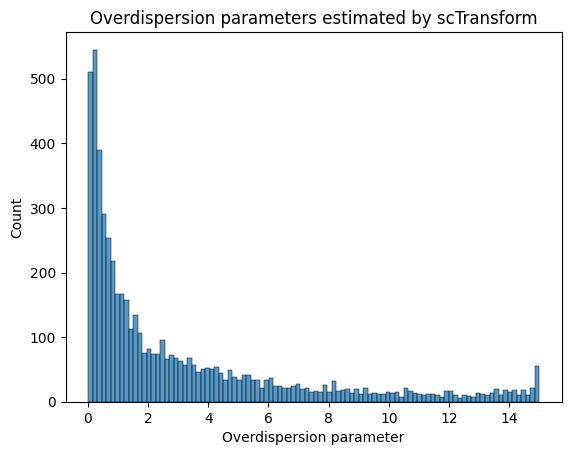

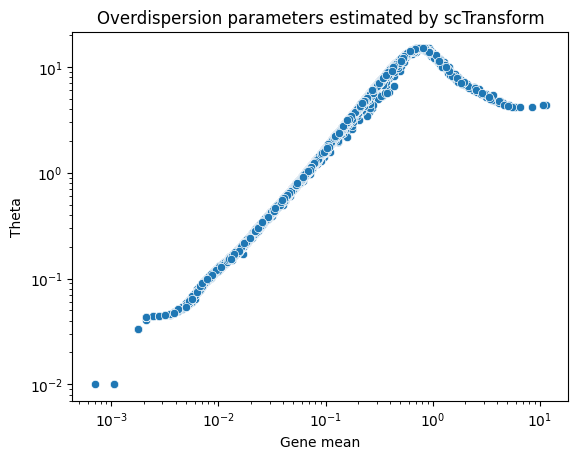

In [21]:
sns.histplot(data=data_gene.var, x="nb_overdisp_cutoff", bins=100)
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Overdispersion parameter")
plt.show()

g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log", yscale="log")
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

In [22]:
data_gene.X = data_gene.layers["counts"].copy()

## Normalization, VST, scaling and PCA

In [23]:
sc.pp.normalize_total(data_gene, target_sum=None, layer=None)
if is_overdispersed:
    data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))
else:
    data_gene.X = sps.csr_matrix(np.sqrt(data_gene.X.toarray()))
data_gene.layers["vst_counts"] = data_gene.X.copy()
sc.pp.scale(data_gene, max_value=10, zero_center=True)
# data_gene.X[np.isnan(data_gene.X)] = 0
sc.tl.pca(data_gene, svd_solver='arpack')

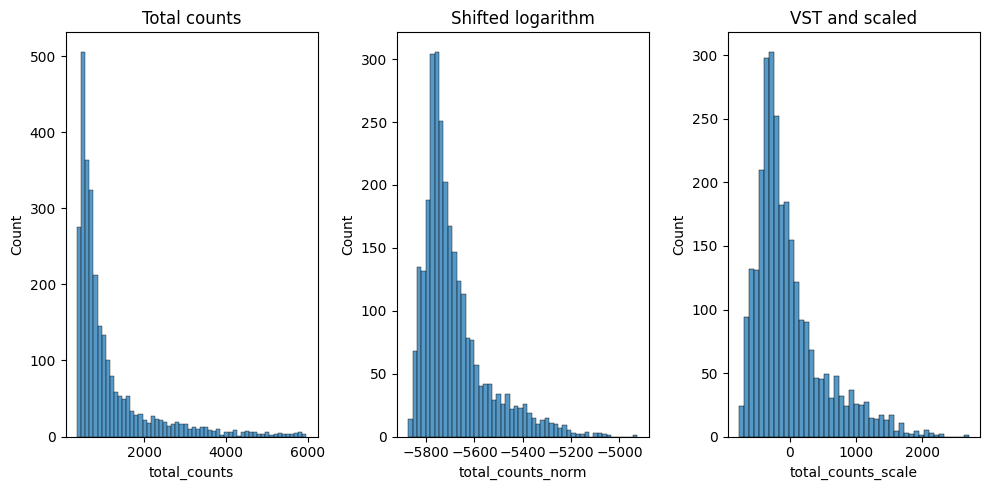

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Total counts")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("Shifted logarithm")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaled")
plt.tight_layout()
plt.show()

## Count-splitting into train and test data

In [66]:
if is_overdispersed:
    data_dist = "NB"
else:
    data_dist = "Poi"
data_train, data_test = cs.countsplit_adata(data_gene, data_dist=data_dist, beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=2345)
print(data_train)

AnnData object with n_obs × n_vars = 2840 × 5545
    obs: 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt', 'n_counts', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std'
    layers: 'counts'


In [67]:
# Transformation, centering and PCA
sc.pp.normalize_total(data_train, target_sum=None, layer=None)
if is_overdispersed:
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    data_train.X = sps.csr_matrix(np.sqrt(data_train.X.toarray()))
data_train.layers["vst_counts"] = data_train.X.copy()
sc.pp.scale(data_train, max_value=10, zero_center=True)
sc.tl.pca(data_train, svd_solver='arpack')


sc.pp.normalize_total(data_test, target_sum=None, layer=None)
if is_overdispersed:
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    data_test.X = sps.csr_matrix(np.sqrt(data_test.X.toarray()))
data_test.layers["vst_counts"] = data_test.X.copy()
sc.pp.scale(data_test, max_value=10, zero_center=True)
sc.tl.pca(data_test, svd_solver='arpack')

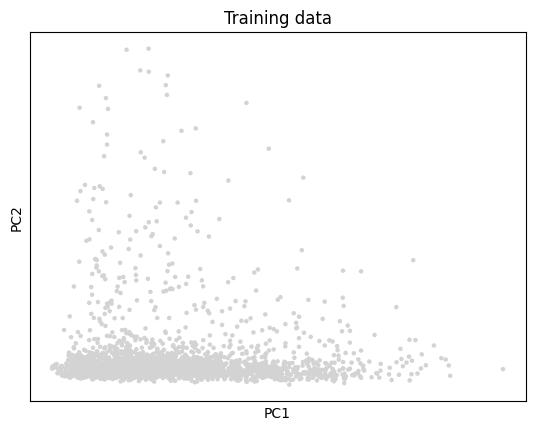

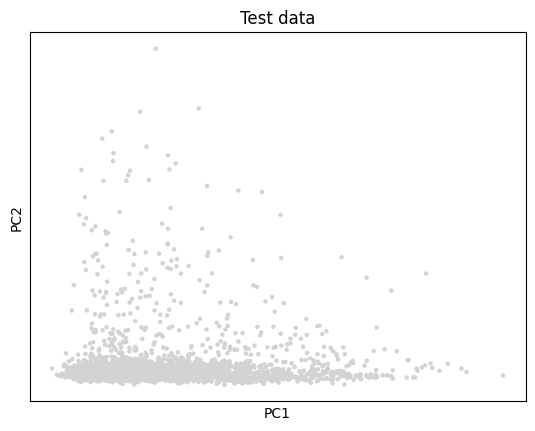

In [68]:
sc.pl.pca(data_train, title="Training data")
plt.show()

sc.pl.pca(data_test, title="Test data")
plt.show()

### Principal component selection

In [69]:
k_errors, k_opt = cs.select_n_pcs_countsplit(data_train, data_test)
print(f"Optimal number of PCs:{k_opt}")

Optimal number of PCs:4


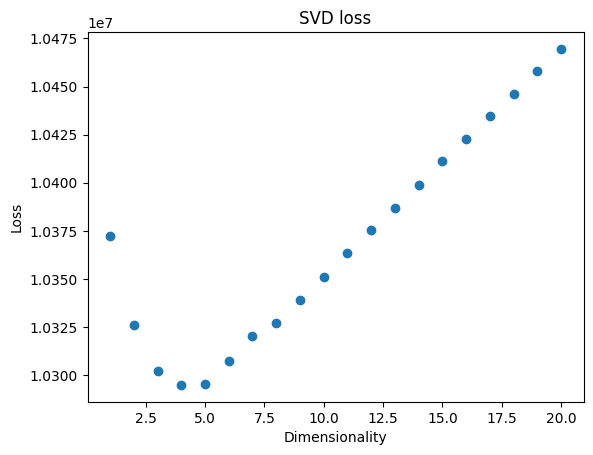

In [70]:
plt.scatter(np.arange(20) + 1, k_errors)
plt.title("SVD loss")
plt.xlabel("Dimensionality")
plt.ylabel("Loss")
plt.show()

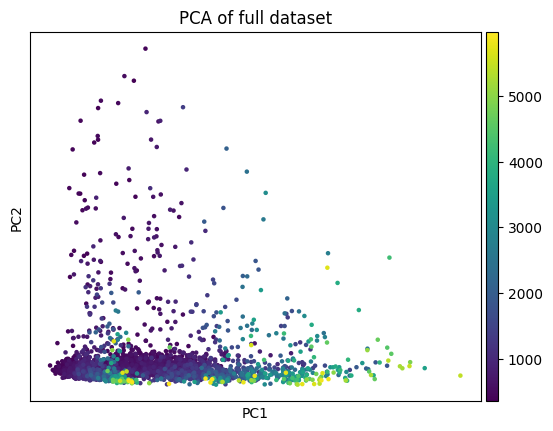

In [71]:
sc.pl.pca(data_gene, color="total_counts", cmap="viridis", title="PCA of full dataset")
plt.show()

In [72]:
data_gene.uns["BacSC_params"] = {"k_opt": k_opt}

## Selection of optimal number of neighbors and optimal UMAP scale via scDEED

In [74]:
rng = np.random.default_rng()
seed = rng.choice(1000)
print(seed)

772


In [75]:
importlib.reload(scd)

n_neighborss = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250]
min_dists = [0.05, 0.1, 0.3, 0.5, 0.7]

scdeed_result, rel_scores, null_rel_scores, reliabilities, n_neighbors_opt, min_dist_opt = scd.scdeed_parameter_selection(data_gene, n_neighborss, min_dists, n_pcs=k_opt, rng_seed=seed, embedding_method="UMAP", similarity_percent=0.5, save_path="S3_filtered_scdeed_temp")

calculating (10, 0.05) - run 1/85
calculating (10, 0.1) - run 2/85
calculating (10, 0.3) - run 3/85
calculating (10, 0.5) - run 4/85
calculating (10, 0.7) - run 5/85
calculating (15, 0.05) - run 6/85
calculating (15, 0.1) - run 7/85
calculating (15, 0.3) - run 8/85
calculating (15, 0.5) - run 9/85
calculating (15, 0.7) - run 10/85
calculating (20, 0.05) - run 11/85
calculating (20, 0.1) - run 12/85
calculating (20, 0.3) - run 13/85
calculating (20, 0.5) - run 14/85
calculating (20, 0.7) - run 15/85
calculating (25, 0.05) - run 16/85
calculating (25, 0.1) - run 17/85
calculating (25, 0.3) - run 18/85
calculating (25, 0.5) - run 19/85
calculating (25, 0.7) - run 20/85
calculating (30, 0.05) - run 21/85
calculating (30, 0.1) - run 22/85
calculating (30, 0.3) - run 23/85
calculating (30, 0.5) - run 24/85
calculating (30, 0.7) - run 25/85
calculating (35, 0.05) - run 26/85
calculating (35, 0.1) - run 27/85
calculating (35, 0.3) - run 28/85
calculating (35, 0.5) - run 29/85
calculating (35, 

Optimal number of neighbors: 30
Optimal min_dist: 0.3


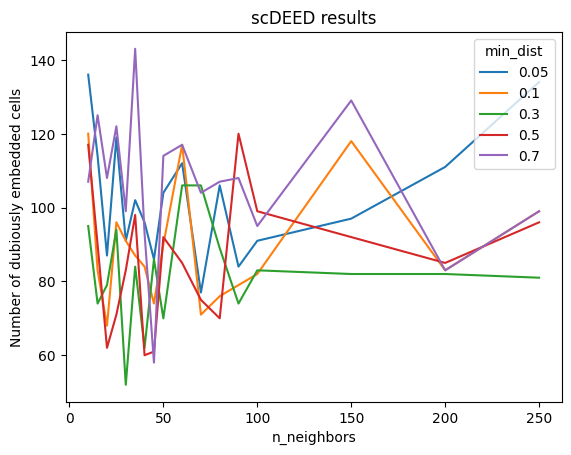

In [76]:
print(f"Optimal number of neighbors: {n_neighbors_opt}")
print(f"Optimal min_dist: {min_dist_opt}")

sns.lineplot(data=scdeed_result, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10")
plt.title("scDEED results")
plt.ylabel("Number of dubiously embedded cells")
plt.show()

In [77]:
data_gene.uns["BacSC_params"]["n_neighbors_opt"] = n_neighbors_opt
data_gene.uns["BacSC_params"]["min_dist_opt"] = min_dist_opt

In [78]:
# k_opt = data_gene.uns["BacSC_params"]["k_opt"]
# n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
# min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]


# k_opt = 4
# n_neighbors_opt = 70
# min_dist_opt = 0.3
# print(k_opt)

In [79]:
sc.pp.neighbors(data_gene, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_gene, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=3456)


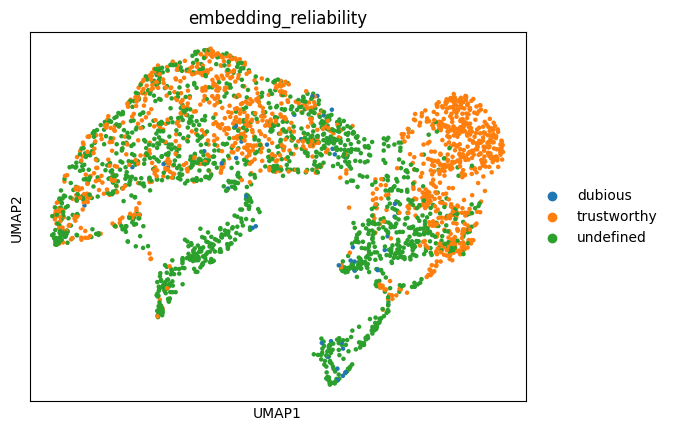

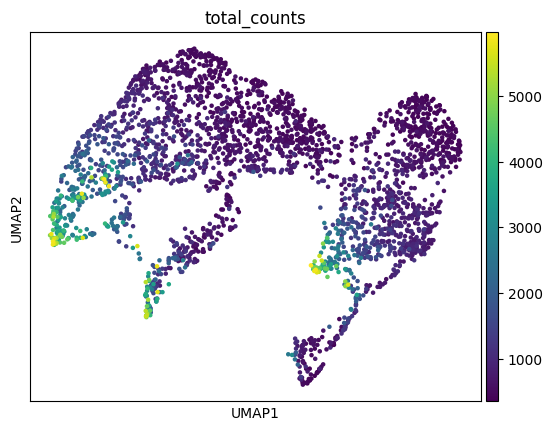

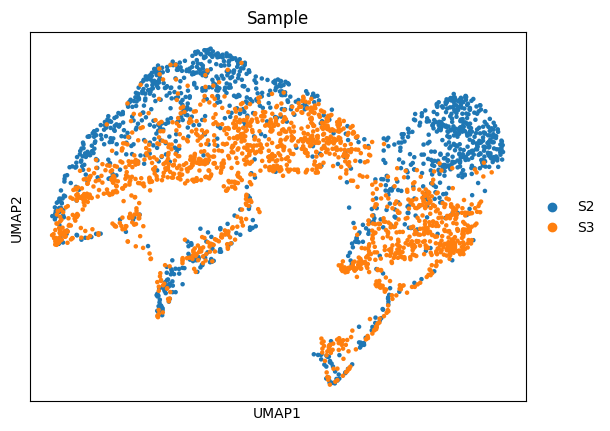

In [80]:
sc.pl.umap(data_gene, color="embedding_reliability", alpha=1)
plt.show()

sc.pl.umap(data_gene, color="total_counts", alpha=1, cmap="viridis")
plt.show()

sc.pl.umap(data_gene, color="Sample")
plt.show()

In [81]:
data_gene.write(data_path + "/S2S3_combined_data_maxpool_processed.h5ad")


## Clustering

### Train/test-split for clustering

In [82]:
sc.pp.neighbors(data_train, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_train, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)

sc.pp.neighbors(data_test, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_test, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)


theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy())
data_test.obsm["X_umap_rot"] = umap_2_opt

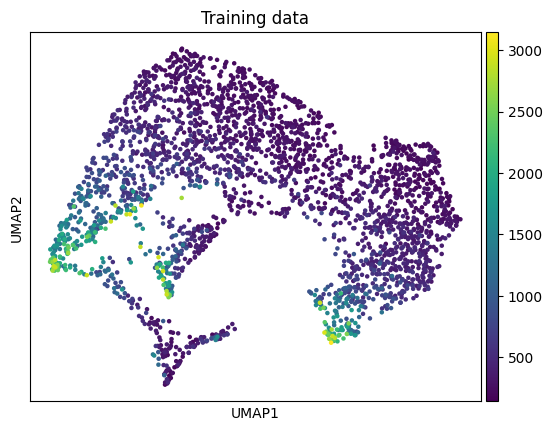

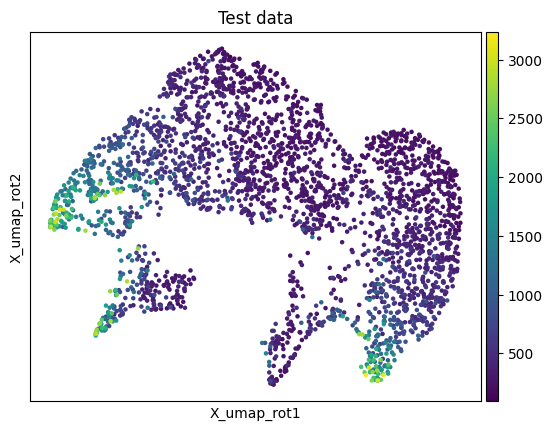

In [83]:
sc.pl.umap(data_train, color="total_counts", cmap="viridis", title="Training data")
plt.show()

sc.pl.embedding(data_test, basis="X_umap_rot", color="total_counts", cmap="viridis", title="Test data")
plt.show()

### Apply clustering with array of resolutions

In [84]:
importlib.reload(co)
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

co.cluster_train_test(data_train, data_test, resolutions, alg="leiden", random_state=5678)

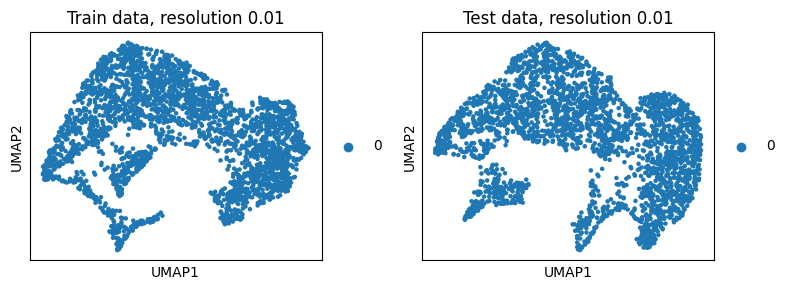

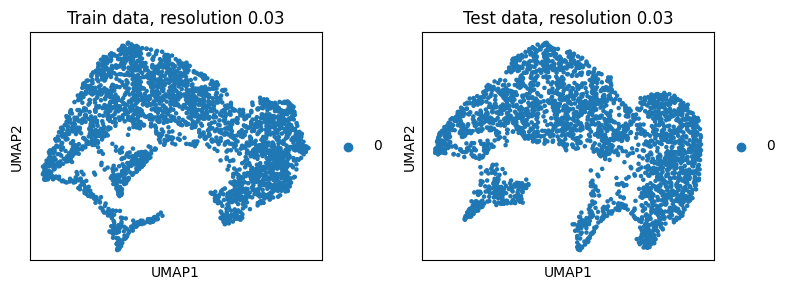

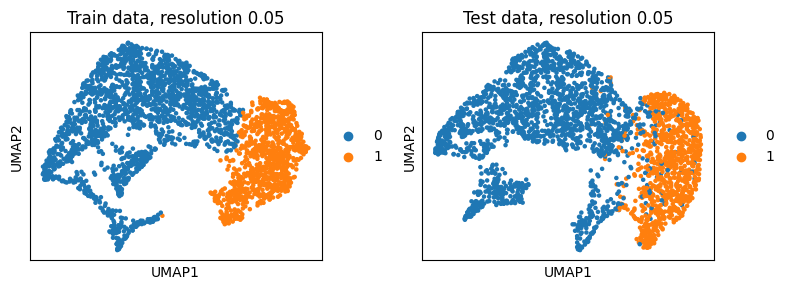

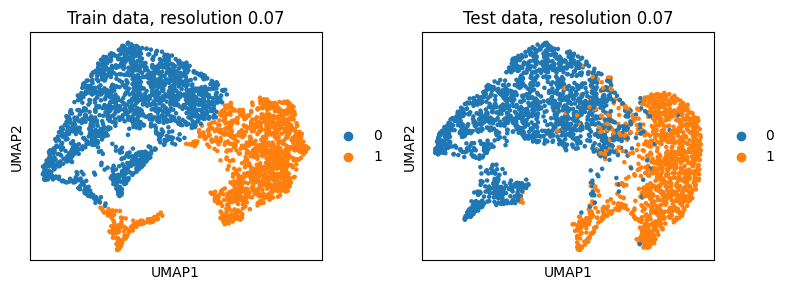

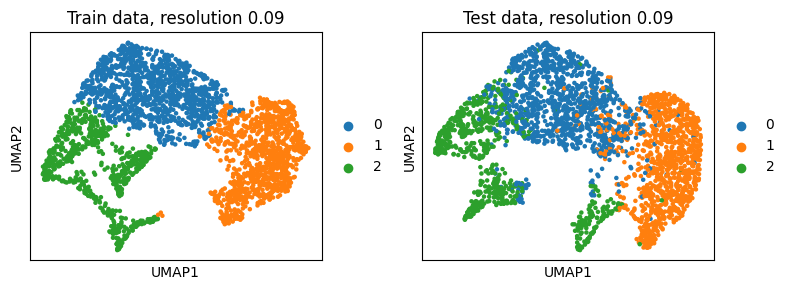

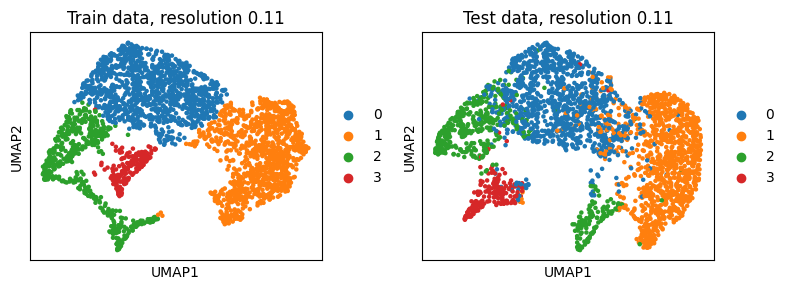

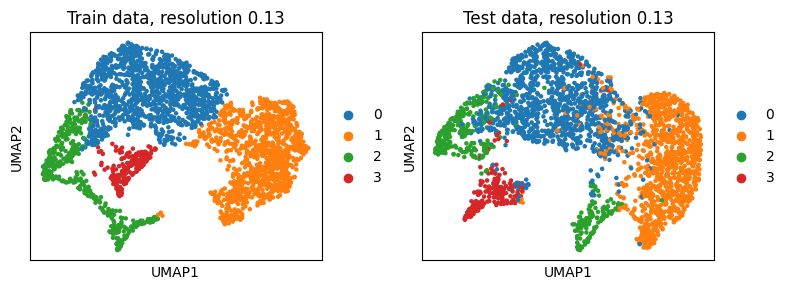

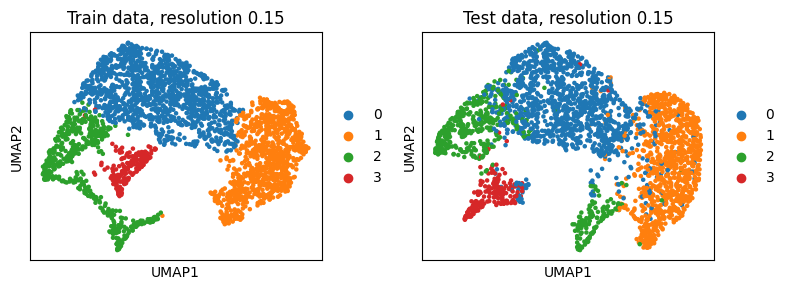

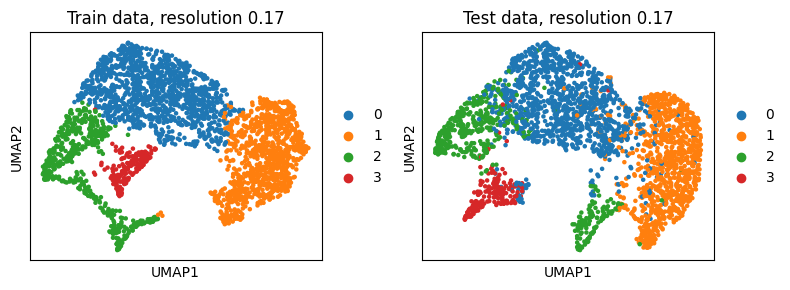

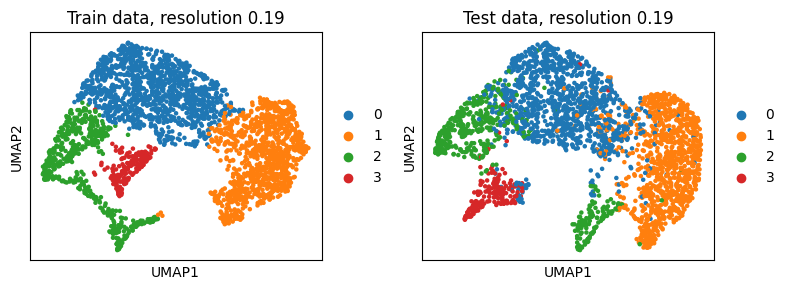

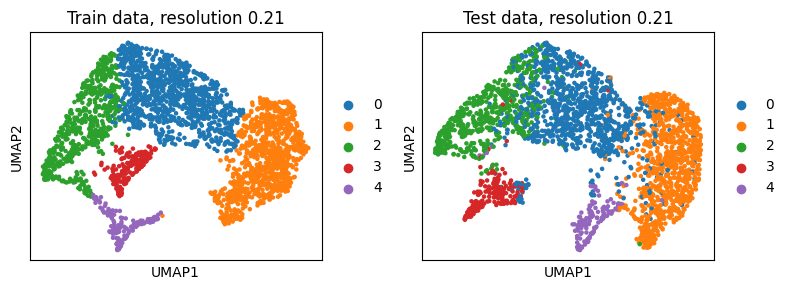

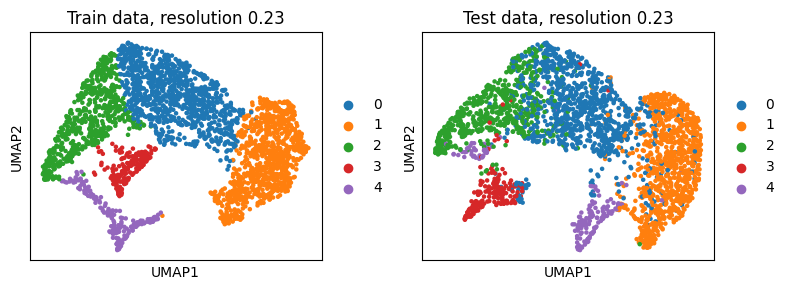

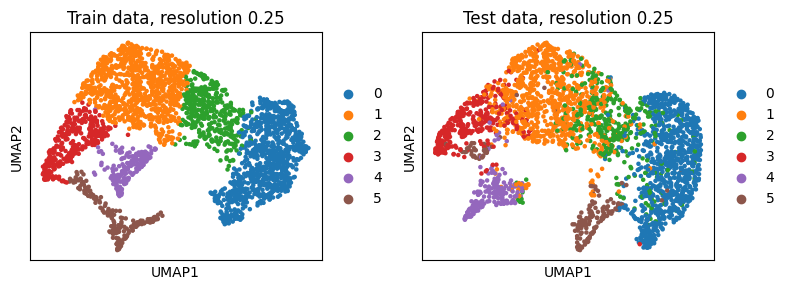

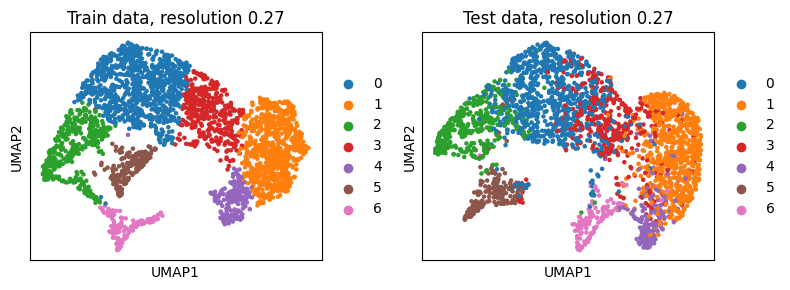

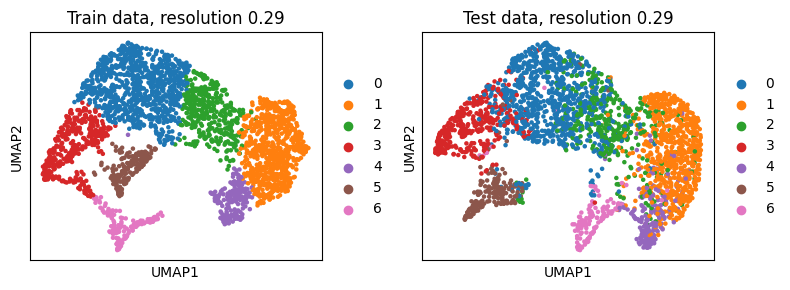

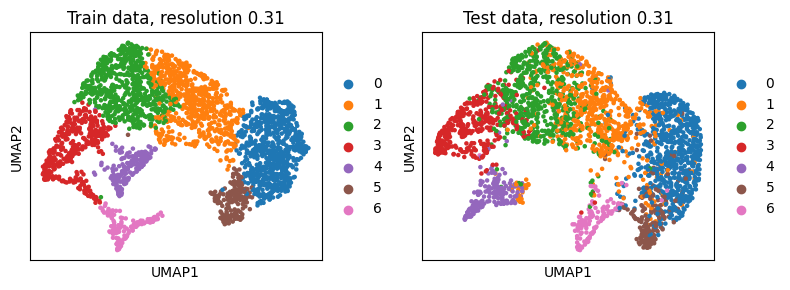

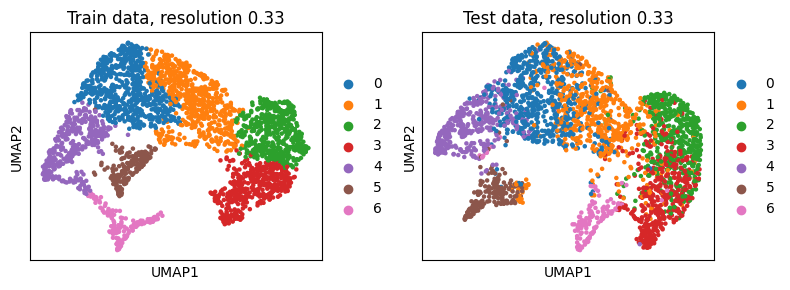

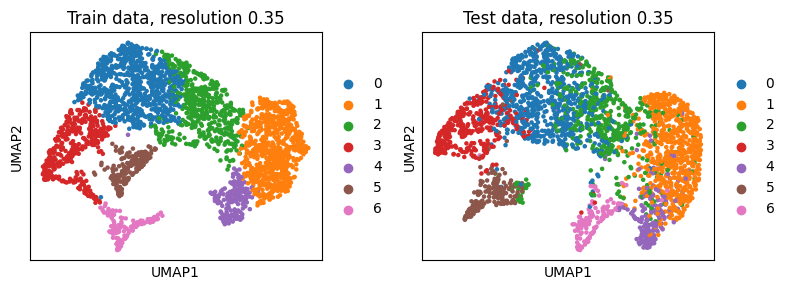

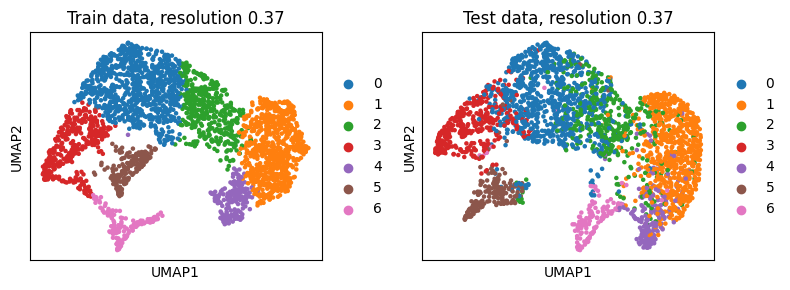

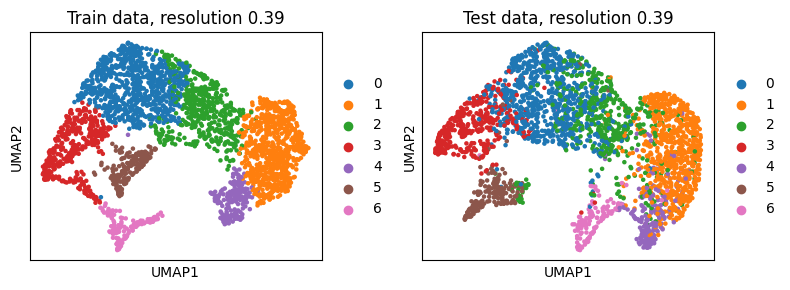

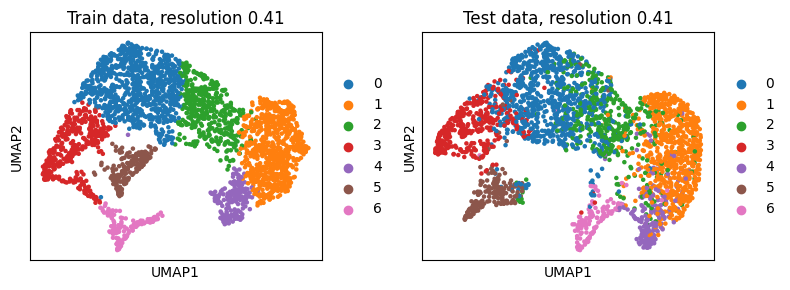

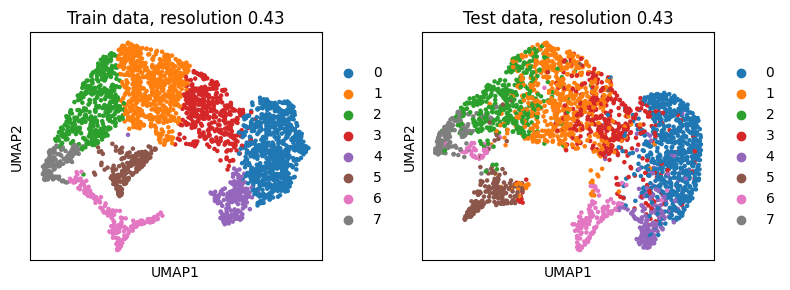

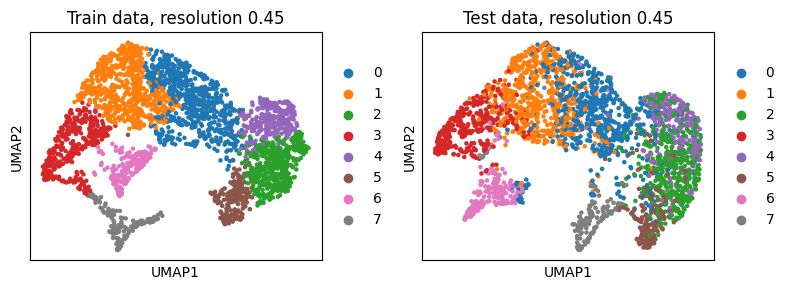

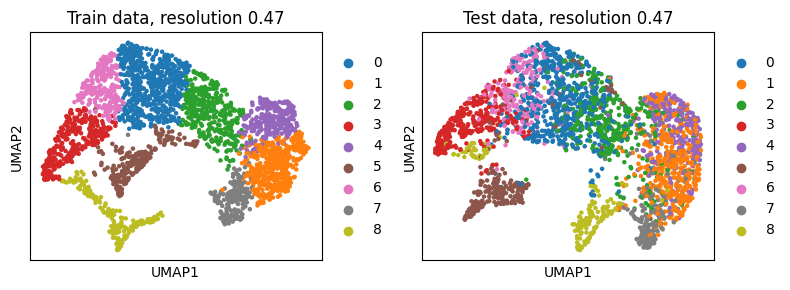

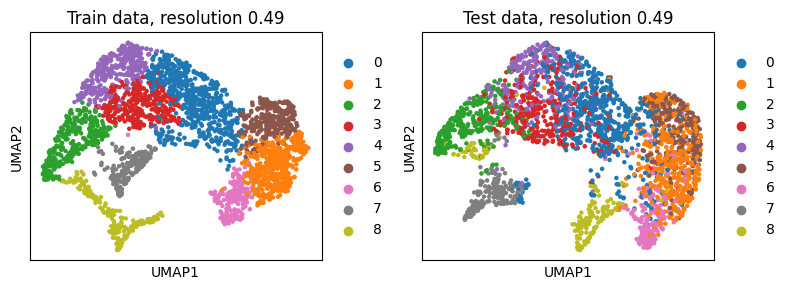

In [85]:
for resolution in resolutions:
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    sc.pl.umap(data_train, color=f"leiden_res{resolution}", ax=ax[0], title=f"Train data, resolution {resolution}", show=False)
    sc.pl.embedding(data_test, basis="X_umap_rot", color=f"leiden_res{resolution}", ax=ax[1], title=f"Test data, resolution {resolution}", show=False)
    ax[1].set_xlabel("UMAP1")
    ax[1].set_ylabel("UMAP2")
    plt.tight_layout()
    plt.show()

Modularities

In [86]:
importlib.reload(co)
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(data_train, data_test, resolutions)

print(f"Optimal resolution {res_opt}")
data_gene.uns["BacSC_params"]["res_opt"] = res_opt


resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.461 - Test: 0.44 - Random: 0.252
resolution: 0.07 - clusters: 2 - Train: 0.453 - Test: 0.426 - Random: 0.22
resolution: 0.09 - clusters: 3 - Train: 0.447 - Test: 0.402 - Random: 0.142
resolution: 0.11 - clusters: 4 - Train: 0.441 - Test: 0.395 - Random: 0.126
resolution: 0.13 - clusters: 4 - Train: 0.432 - Test: 0.389 - Random: 0.123
resolution: 0.15 - clusters: 4 - Train: 0.426 - Test: 0.385 - Random: 0.113
resolution: 0.17 - clusters: 4 - Train: 0.42 - Test: 0.378 - Random: 0.106
resolution: 0.19 - clusters: 4 - Train: 0.414 - Test: 0.371 - Random: 0.098
resolution: 0.21 - clusters: 5 - Train: 0.411 - Test: 0.36 - Random: 0.081
resolution: 0.23 - clusters: 5 - Train: 0.404 - Test: 0.348 - Random: 0.074
resolution: 0.25 - clusters: 6 - Train: 0.4 - Test: 0.327 - Random: 0.059
resolution: 0.27 - clust

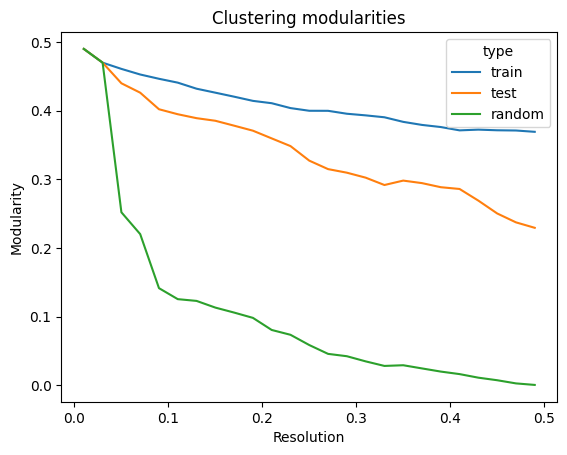

In [87]:
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Modularity")
plt.show()

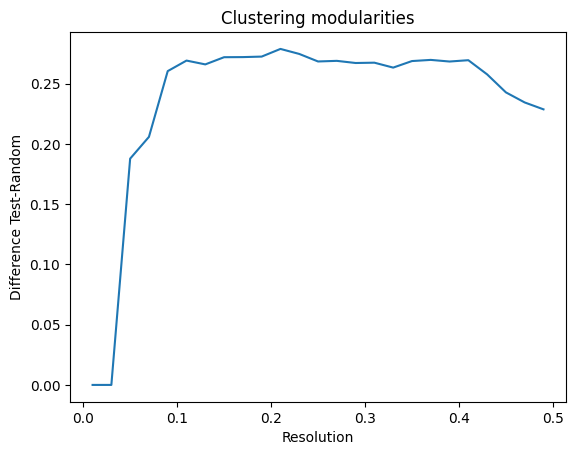

In [88]:
sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Difference Test-Random")
plt.show()

## Cluster analysis

Optimal Leiden resolution: Maximal difference between random and test

In [30]:
data_gene = sc.read_h5ad(data_path + "/S2S3_combined_data_maxpool_processed.h5ad")

In [37]:
res_opt = 0.21
sc.tl.leiden(data_gene, resolution=res_opt, key_added="leiden_opt", random_state=3564)

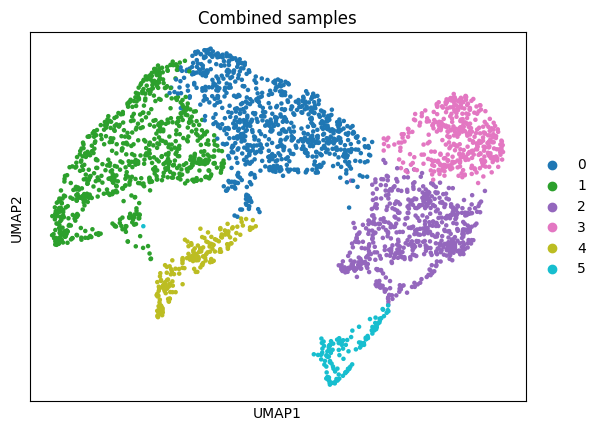

In [38]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Combined samples")
plt.show()

In [39]:
data_gene.write(data_path + "/S2S3_combined_data_maxpool_processed.h5ad")

## Attach feature table

In [5]:
data_gene = sc.read_h5ad(data_path + "/S2S3_combined_data_maxpool_processed.h5ad")
data_gene

AnnData object with n_obs × n_vars = 2840 × 5557
    obs: 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std'
    uns: 'BacSC_params', 'Sample_colors', 'embedding_reliability_colors', 'leiden_opt', 'leiden_opt_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'connectivities', 'distances'

In [6]:
data_gene.var

n_cells_by_counts  mean_counts  log1p_mean_counts  \
PA0001               1283     0.631690           0.489616   
PA0002                958     0.459155           0.377857   
PA0003               1535     0.866549           0.624091   
PA0004                804     0.359507           0.307122   
PA0005                303     0.122535           0.115590   
...                   ...          ...                ...   
PA5566                 21     0.007746           0.007717   
PA5567                317     0.132746           0.124645   
PA5568               1243     0.616197           0.480076   
PA5569               2575     3.328521           1.465226   
PA5570                794     0.414789           0.346980   

        pct_dropout_by_counts  total_counts  log1p_total_counts  n_cells  \
PA0001              54.823944        1794.0            7.492760     1283   
PA0002              66.267606        1304.0            7.173958      958   
PA0003              45.950704        2461.0            7.808729     1535   
PA0004              71.690141        1021.0            6.929517      804   
PA0005              89.330986         348.0            5.855072      303   
...                       ...           ...                 ...      ...   
PA5566              99.260563          22.0            3.135494       21   
PA5567              88.838028         377.0            5.934894      317   
PA5568              56.232394        1750.0            7.467942     1243   
PA5569               9.330986        9453.0            9.154193     2575   
PA5570              72.042254        1178.0            7.072422      794   

        var_counts  is_scd_outlier  nb_overdisp  nb_overdisp_cutoff  \
PA0001    0.740404           False    14.352036           14.352036   
PA0002    0.605374           False    10.736381           10.736381   
PA0003    1.239585           False    14.461098           14.461098   
PA0004    0.415473           False     8.356774            8.356774   
PA0005    0.143436           False     2.177469            2.177469   
...            ...             ...          ...                 ...   
PA5566    0.008391           False     0.098094            0.098094   
PA5567    0.161604           False     2.375922            2.375922   
PA5568    0.748470           False    14.096996           14.096996   
PA5569   14.483975           False     5.250319            5.250319   
PA5570    0.667387           False     9.090777            9.090777   

          nb_mean    nb_umi  Intercept_step1_sct  log_umi_step1_sct  \
PA0001  -7.062211  2.172720            -6.763745           2.070944   
PA0002  -7.706607  2.265225                  NaN                NaN   
PA0003  -6.574947  2.114107                  NaN                NaN   
PA0004  -8.147208  2.332144                  NaN                NaN   
PA0005 -10.076213  2.596174                  NaN                NaN   
...           ...       ...                  ...                ...   
PA5566 -13.225407  2.710316                  NaN                NaN   
PA5567  -9.965291  2.583191                  NaN                NaN   
PA5568  -7.118315  2.180212            -6.983166           2.132635   
PA5569  -5.040659  2.050410            -5.772378           2.282947   
PA5570  -8.004227  2.310420                  NaN                NaN   

        dispersion_step1_sct      mean       std  
PA0001              0.009562  1.380827  0.140674  
PA0002                   NaN  1.079745  0.157803  
PA0003                   NaN  1.422187  0.159145  
PA0004                   NaN  0.825503  0.170925  
PA0005                   NaN -0.531116  0.254086  
...                      ...       ...       ...  
PA5566                   NaN -3.684671  0.280471  
PA5567                   NaN -0.440449  0.260701  
PA5568              0.010138  1.360124  0.141412  
PA5569              0.085403  1.164406  0.432854  
PA5570                   NaN  0.916785  0.184485  

[5557 rows x 18 columns]

In [7]:
feature_table = pd.read_csv("../../data/MOBA_scRNAseq/P_aeruginosa_PAO1_feature_table.tsv", sep="\t")
feature_table = feature_table[["Locus tag", "Protein accession", "Name", "Symbol"]]
feature_table["Locus tag"] = [str(x) for x in feature_table["Locus tag"]]
feature_table

Locus tag Protein accession  \
0       PA0001       NP_064721.1   
1       PA0002       NP_064722.1   
2       PA0003       NP_064723.1   
3       PA0004       NP_064724.1   
4       PA0005       NP_064725.1   
...        ...               ...   
5692    PA5566       NP_254253.1   
5693    PA5567       NP_254254.1   
5694    PA5568       NP_254255.1   
5695    PA5569       NP_254256.1   
5696    PA5570       NP_254257.1   

                                                 Name Symbol  
0               chromosome replication initiator DnaA   dnaA  
1                     DNA polymerase III subunit beta   dnaN  
2             DNA replication and repair protein RecF   recF  
3                                DNA gyrase subunit B   gyrB  
4               lysophosphatidic acid acyltransferase   lptA  
...                                               ...    ...  
5692                             hypothetical protein    NaN  
5693                    tRNA modification GTPase TrmE    NaN  
5694  inner membrane protein translocase subunit YidC    NaN  
5695                                   ribonuclease P   rnpA  
5696                        50S ribosomal protein L34   rpmH  

[5697 rows x 4 columns]

In [8]:
df3=data_gene.var.reset_index().merge(feature_table, how='left', left_on='index', right_on='Locus tag').drop_duplicates("index").set_index("index")
data_gene.var = df3


In [9]:
data_gene.var

n_cells_by_counts  mean_counts  log1p_mean_counts  \
index                                                       
PA0001               1283     0.631690           0.489616   
PA0002                958     0.459155           0.377857   
PA0003               1535     0.866549           0.624091   
PA0004                804     0.359507           0.307122   
PA0005                303     0.122535           0.115590   
...                   ...          ...                ...   
PA5566                 21     0.007746           0.007717   
PA5567                317     0.132746           0.124645   
PA5568               1243     0.616197           0.480076   
PA5569               2575     3.328521           1.465226   
PA5570                794     0.414789           0.346980   

        pct_dropout_by_counts  total_counts  log1p_total_counts  n_cells  \
index                                                                      
PA0001              54.823944        1794.0            7.492760     1283   
PA0002              66.267606        1304.0            7.173958      958   
PA0003              45.950704        2461.0            7.808729     1535   
PA0004              71.690141        1021.0            6.929517      804   
PA0005              89.330986         348.0            5.855072      303   
...                       ...           ...                 ...      ...   
PA5566              99.260563          22.0            3.135494       21   
PA5567              88.838028         377.0            5.934894      317   
PA5568              56.232394        1750.0            7.467942     1243   
PA5569               9.330986        9453.0            9.154193     2575   
PA5570              72.042254        1178.0            7.072422      794   

        var_counts  is_scd_outlier  nb_overdisp  ...    nb_umi  \
index                                            ...             
PA0001    0.740404           False    14.352036  ...  2.172720   
PA0002    0.605374           False    10.736381  ...  2.265225   
PA0003    1.239585           False    14.461098  ...  2.114107   
PA0004    0.415473           False     8.356774  ...  2.332144   
PA0005    0.143436           False     2.177469  ...  2.596174   
...            ...             ...          ...  ...       ...   
PA5566    0.008391           False     0.098094  ...  2.710316   
PA5567    0.161604           False     2.375922  ...  2.583191   
PA5568    0.748470           False    14.096996  ...  2.180212   
PA5569   14.483975           False     5.250319  ...  2.050410   
PA5570    0.667387           False     9.090777  ...  2.310420   

        Intercept_step1_sct  log_umi_step1_sct  dispersion_step1_sct  \
index                                                                  
PA0001            -6.763745           2.070944              0.009562   
PA0002                  NaN                NaN                   NaN   
PA0003                  NaN                NaN                   NaN   
PA0004                  NaN                NaN                   NaN   
PA0005                  NaN                NaN                   NaN   
...                     ...                ...                   ...   
PA5566                  NaN                NaN                   NaN   
PA5567                  NaN                NaN                   NaN   
PA5568            -6.983166           2.132635              0.010138   
PA5569            -5.772378           2.282947              0.085403   
PA5570                  NaN                NaN                   NaN   

            mean       std  Locus tag  Protein accession  \
index                                                      
PA0001  1.380827  0.140674     PA0001        NP_064721.1   
PA0002  1.079745  0.157803     PA0002        NP_064722.1   
PA0003  1.422187  0.159145     PA0003        NP_064723.1   
PA0004  0.825503  0.170925     PA0004        NP_064724.1   
PA0005 -0.531116  0.254086     PA0005        NP_064725.1   
...      

In [12]:
data_gene.write(data_path + "/S2S3_combined_data_maxpool_processed.h5ad")

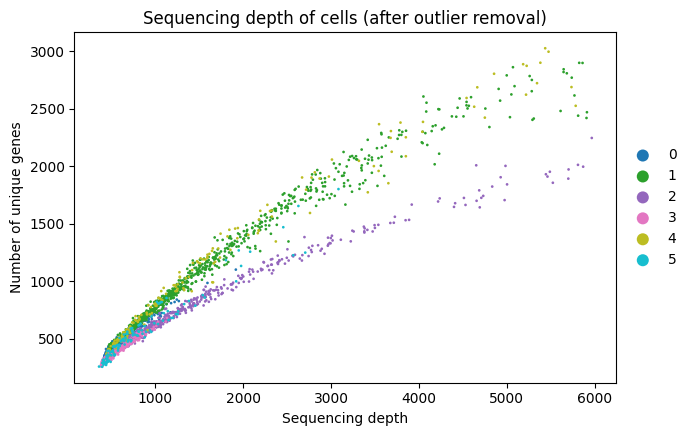

In [40]:
## Attach feature table

data_path = "../../data/MOBA_scRNAseq/outs_S3"
data_gene = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed.h5ad")
data_gene

data_gene.var

feature_table = pd.read_csv("../../data/MOBA_scRNAseq/P_aeruginosa_PAO1_feature_table.tsv", sep="\t")
feature_table = feature_table[["Locus tag", "Protein accession", "Name", "Symbol"]]
feature_table["Locus tag"] = [str(x) for x in feature_table["Locus tag"]]
feature_table

df3=data_gene.var.reset_index().merge(feature_table, how='left', left_on='index', right_on='Locus tag').drop_duplicates("index").set_index("index")
data_gene.var = df3


data_gene.write(data_path + "/filtered_data_maxpool_processed.h5ad")sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="leiden_opt")
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

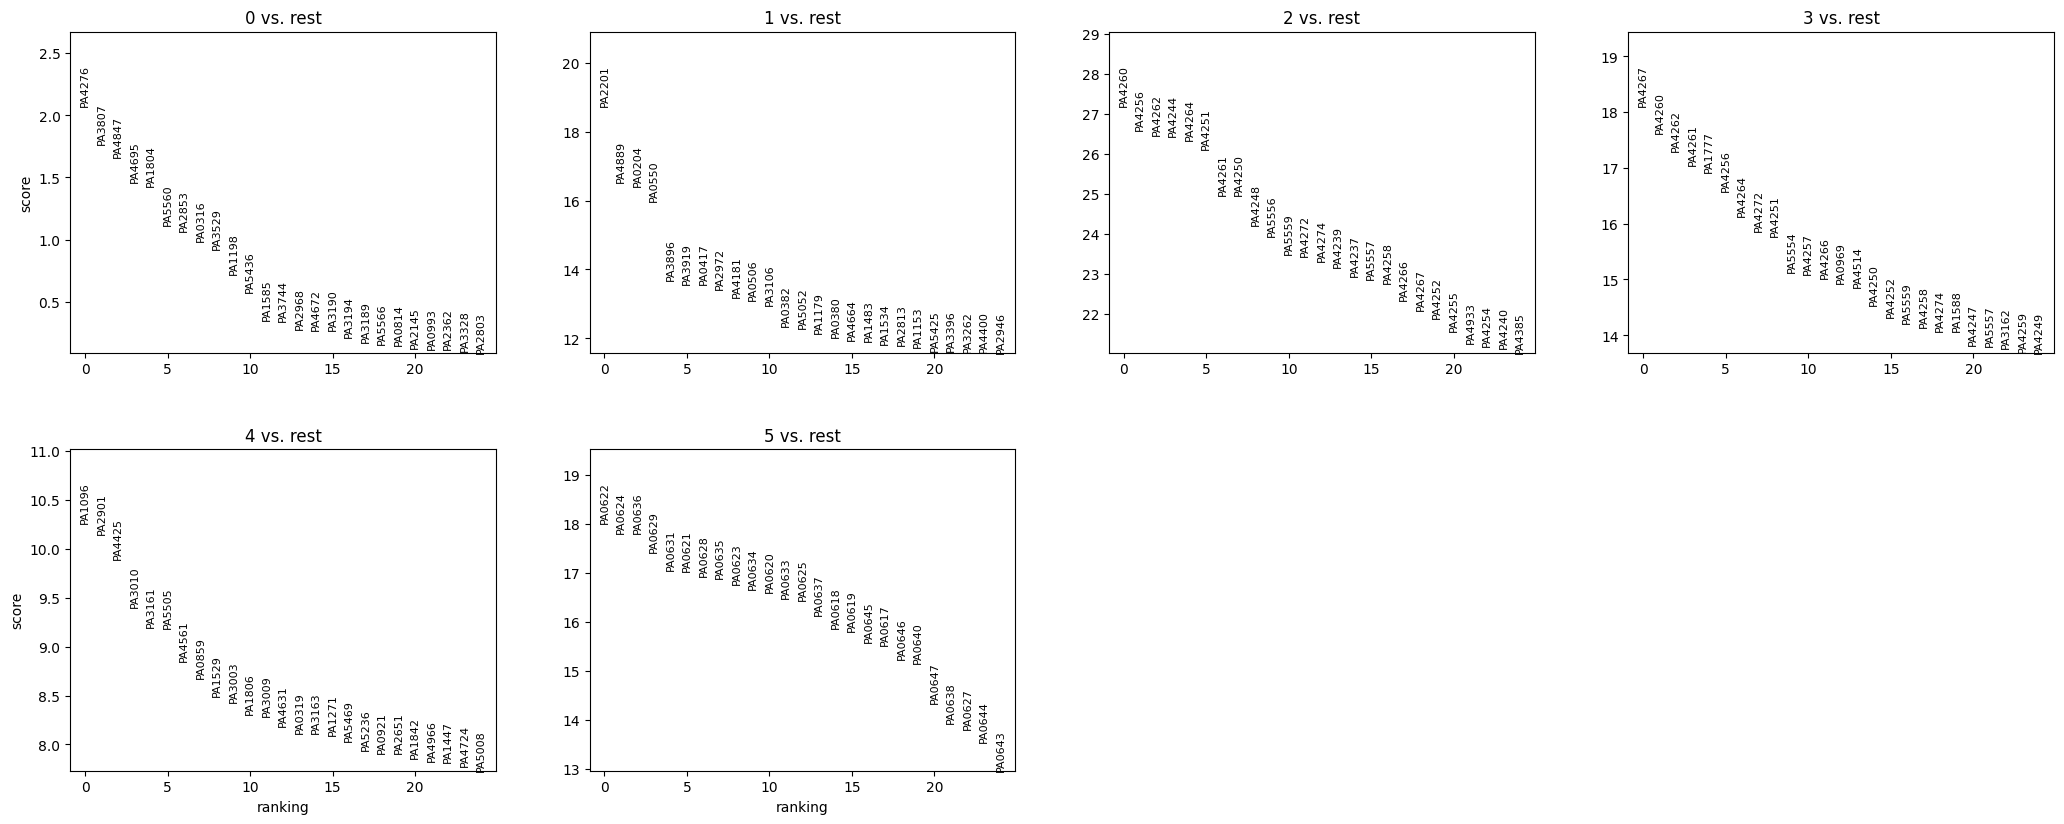

In [41]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

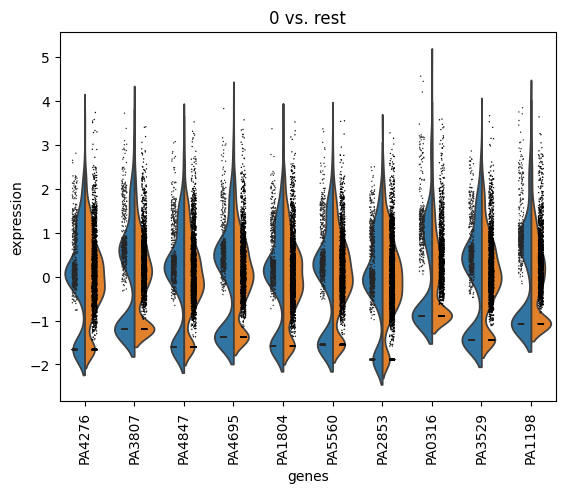

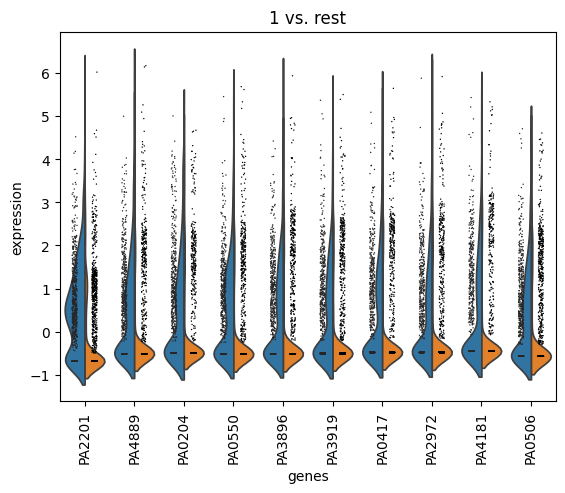

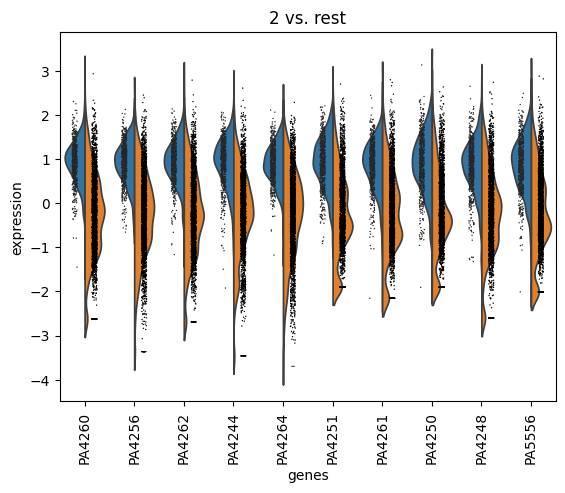

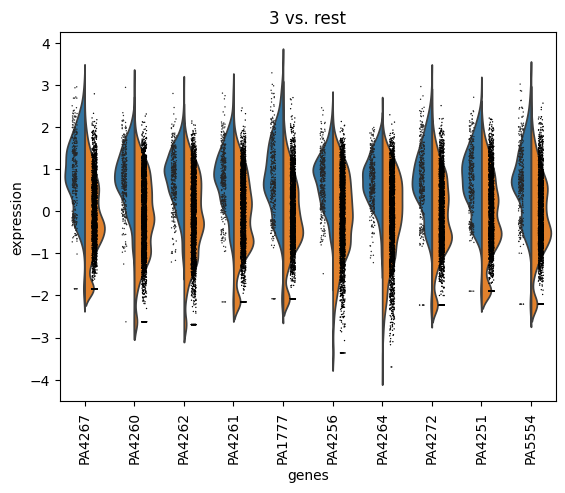

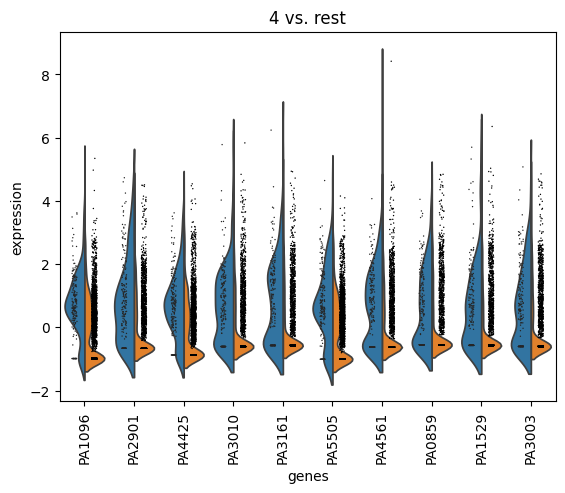

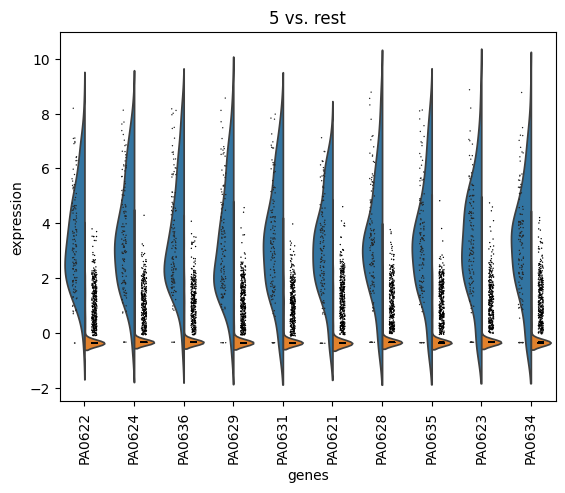

In [42]:
nclust = len(np.unique(data_gene.obs["leiden_opt"]))

for i in range(nclust):
    sc.pl.rank_genes_groups_violin(data_gene, groups=str(i), n_genes=10)

## Comparison with bulk results

In [9]:
data_path = "../../data/MOBA_scRNAseq"
data_gene = sc.read_h5ad(data_path + "/S2S3_combined_data_maxpool_processed.h5ad")
px_da = pd.read_csv(data_path + "/combined_S2S3/low_iron_analysis.tsv", sep="\t")
px_da

locus_tag  copathogenex  logistic_regression  differential_expression  \
0      PA4361          True                False                    False   
1      PA5144         False                False                     True   
2      PA1028          True                False                     True   
3      PA4750          True                False                    False   
4      PA2185          True                False                    False   
..        ...           ...                  ...                      ...   
404    PA5199          True                False                    False   
405    PA3161          True                False                    False   
406    PA3523          True                 True                     True   
407    PA1134         False                False                     True   
408    PA4637         False                False                     True   

                                                  Name Genes  \
0                                       oxidoreductase   NaN   
1                                 hypothetical protein   NaN   
2                                       oxidoreductase   NaN   
3                             dihydropteroate synthase   NaN   
4                               non-heme catalase KatN  katN   
..                                                 ...   ...   
404                                       protein AmgS   NaN   
405               integration host factor subunit beta  ihfB   
406  resistance-nodulation-cell division (RND) effl...   NaN   
407                               hypothetical protein   NaN   
408                               hypothetical protein   NaN   

                                    PGFam  
0                                     NaN  
1                                     NaN  
2          L-pipecolate oxidase (1.5.3.7)  
3                                     NaN  
4        Manganese catalase (EC 1.11.1.6)  
..                                    ...  
404                                   NaN  
405  Integration host factor beta subunit  
406                                   NaN  
407     probable membrane protein YPO1564  
408                                   NaN  

[409 rows x 7 columns]

In [10]:
sc.tl.rank_genes_groups(data_gene, 'Sample', method='wilcoxon')
px_da.index = px_da["locus_tag"]
dedf = sc.get.rank_genes_groups_df(data_gene, group="S2")
dedf["Wilcoxon"] = dedf["pvals_adj"] < 0.01
dedf.index=dedf["names"]
dedf

names     scores  logfoldchanges          pvals      pvals_adj  \
names                                                                     
PA4514  PA4514  29.418455             NaN  3.189375e-190  1.772336e-186   
PA4370  PA4370  22.473743             NaN  7.499666e-112  2.083782e-108   
PA4675  PA4675  20.636263             NaN   1.297126e-94   2.402710e-91   
PA4515  PA4515  20.410872             NaN   1.338767e-92   1.859882e-89   
PA0969  PA0969  20.266094             NaN   2.562056e-91   2.847470e-88   
...        ...        ...             ...            ...            ...   
PA4429  PA4429  -7.714039             NaN   1.218967e-14   2.709521e-12   
PA1689  PA1689  -7.924431             NaN   2.291935e-15   5.537514e-13   
PA5558  PA5558  -9.000774             NaN   2.241302e-19   5.661325e-17   
PA2071  PA2071 -10.095086             NaN   5.807982e-24   2.151664e-21   
PA3531  PA3531 -16.775068             NaN   3.714369e-63   2.948678e-60   

        Wilcoxon  
names             
PA4514      True  
PA4370      True  
PA4675      True  
PA4515      True  
PA0969      True  
...          ...  
PA4429      True  
PA1689      True  
PA5558      True  
PA2071      True  
PA3531      True  

[5557 rows x 6 columns]

In [11]:
total_compare = pd.merge(px_da, dedf, left_index=True, right_index=True, how="outer")
total_compare

locus_tag copathogenex logistic_regression differential_expression  \
PA0001       NaN          NaN                 NaN                     NaN   
PA0002       NaN          NaN                 NaN                     NaN   
PA0003       NaN          NaN                 NaN                     NaN   
PA0004       NaN          NaN                 NaN                     NaN   
PA0005       NaN          NaN                 NaN                     NaN   
...          ...          ...                 ...                     ...   
PA5566    PA5566         True               False                   False   
PA5567       NaN          NaN                 NaN                     NaN   
PA5568       NaN          NaN                 NaN                     NaN   
PA5569       NaN          NaN                 NaN                     NaN   
PA5570       NaN          NaN                 NaN                     NaN   

                        Name Genes PGFam   names    scores  logfoldchanges  \
PA0001                   NaN   NaN   NaN  PA0001 -2.184367             NaN   
PA0002                   NaN   NaN   NaN  PA0002 -1.439772             NaN   
PA0003                   NaN   NaN   NaN  PA0003 -2.443302             NaN   
PA0004                   NaN   NaN   NaN  PA0004 -1.876775             NaN   
PA0005                   NaN   NaN   NaN  PA0005 -1.174212             NaN   
...                      ...   ...   ...     ...       ...             ...   
PA5566  hypothetical protein   NaN   NaN  PA5566 -0.158375             NaN   
PA5567                   NaN   NaN   NaN  PA5567 -0.326343             NaN   
PA5568                   NaN   NaN   NaN  PA5568 -3.913074             NaN   
PA5569                   NaN   NaN   NaN  PA5569 -0.665247             NaN   
PA5570                   NaN   NaN   NaN  PA5570 -3.188541             NaN   

           pvals  pvals_adj Wilcoxon  
PA0001  0.028935   0.238741    False  
PA0002  0.149932   0.660638    False  
PA0003  0.014554   0.150544    False  
PA0004  0.060549   0.384538    False  
PA0005  0.240310   0.854931    False  
...          ...        ...      ...  
PA5566  0.874162   0.999831    False  
PA5567  0.744165   0.999831    False  
PA5568  0.000091   0.003422     True  
PA5569  0.505893   0.999831    False  
PA5570  0.001430   0.028987    False  

[5559 rows x 13 columns]

186


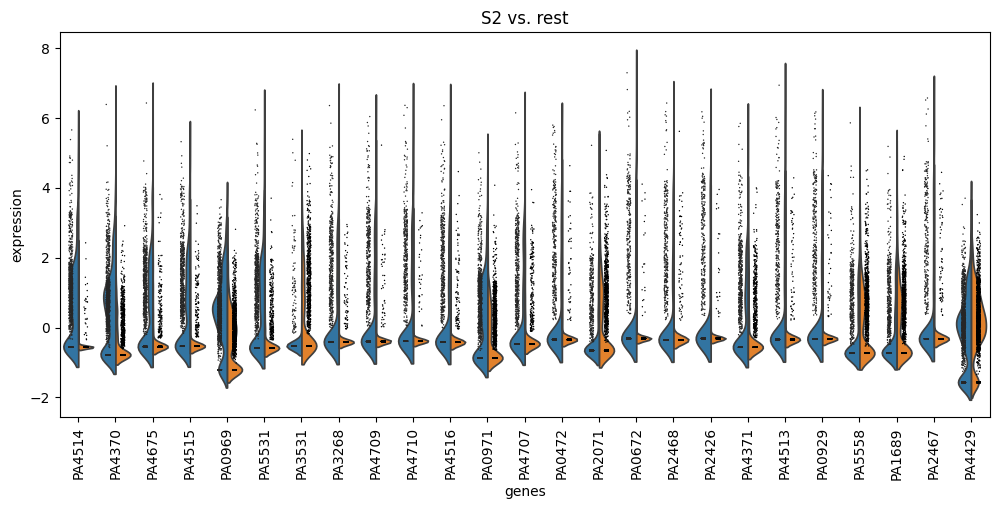

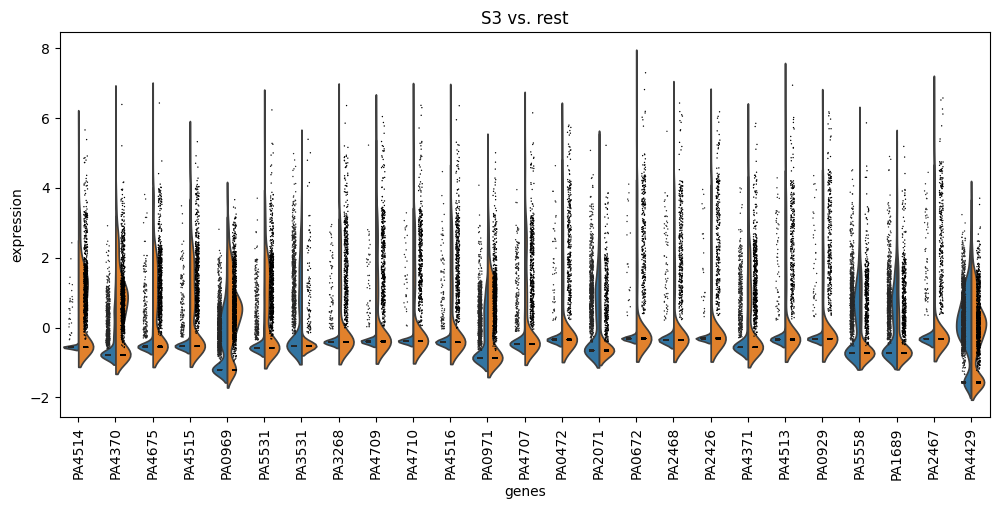

In [ ]:
genes_de = dedf[dedf["Wilcoxon"] == True].sort_values("pvals_adj", ascending=True).index
print(len(genes_de))
with plt.rc_context({"figure.figsize": (12, 5)}):
    sc.pl.rank_genes_groups_violin(data_gene, gene_names=genes_de.tolist()[:25])


In [13]:
total_compare[["copathogenex", "logistic_regression", "differential_expression"]] = total_compare[["copathogenex", "logistic_regression", "differential_expression"]].fillna(False)
total_compare = total_compare.sort_values("pvals_adj", ascending=True)
total_compare["Wilcoxon_rank"] = np.arange(len(total_compare)) + 1
total_compare

locus_tag  copathogenex  logistic_regression  differential_expression  \
PA4514    PA4514         False                 True                     True   
PA4370    PA4370          True                False                    False   
PA4675       NaN         False                False                    False   
PA4515    PA4515          True                 True                     True   
PA0969       NaN         False                False                    False   
...          ...           ...                  ...                      ...   
PA2479       NaN         False                False                    False   
PA2788       NaN         False                False                    False   
PA4308       NaN         False                False                    False   
PA0748    PA0748         False                False                     True   
PA1029    PA1029         False                False                     True   

                                                     Name Genes PGFam   names  \
PA4514             iron transport outer membrane receptor   NaN   NaN  PA4514   
PA4370  insulin-cleaving metalloproteinase outer membr...   NaN   NaN  PA4370   
PA4675                                                NaN   NaN   NaN  PA4675   
PA4515                                        hydroxylase   NaN   NaN  PA4515   
PA0969                                                NaN   NaN   NaN  PA0969   
...                                                   ...   ...   ...     ...   
PA2479                                                NaN   NaN   NaN  PA2479   
PA2788                                                NaN   NaN   NaN  PA2788   
PA4308                                                NaN   NaN   NaN  PA4308   
PA0748                               uncharacterized gene   NaN   NaN     NaN   
PA1029                               uncharacterized gene   NaN   NaN     NaN   

           scores  logfoldchanges          pvals      pvals_adj Wilcoxon  \
PA4514  29.418455             NaN  3.189375e-190  1.772336e-186     True   
PA4370  22.473743             NaN  7.499666e-112  2.083782e-108     True   
PA4675  20.636263             NaN   1.297126e-94   2.402710e-91     True   
PA4515  20.410872             NaN   1.338767e-92   1.859882e-89     True   
PA0969  20.266094             NaN   2.562056e-91   2.847470e-88     True   
...           ...             ...            ...            ...      ...   
PA2479  -0.301726             NaN   7.628610e-01   9.998312e-01    False   
PA2788  -0.487938             NaN   6.255938e-01   9.998312e-01    False   
PA4308   0.000023             NaN   9.999816e-01   9.999816e-01    False   
PA0748        NaN             NaN            NaN            NaN      NaN   
PA1029        NaN             NaN            NaN            NaN      NaN   

        Wilcoxon_rank  
PA4514              1  
PA4370              2  
PA4675              3  
PA4515              4  
PA0969              5  
...               ...  
PA2479           5555  
PA2788           5556  
PA4308           5557  
PA0748           5558  
PA1029           5559  

[5559 rows x 14 columns]

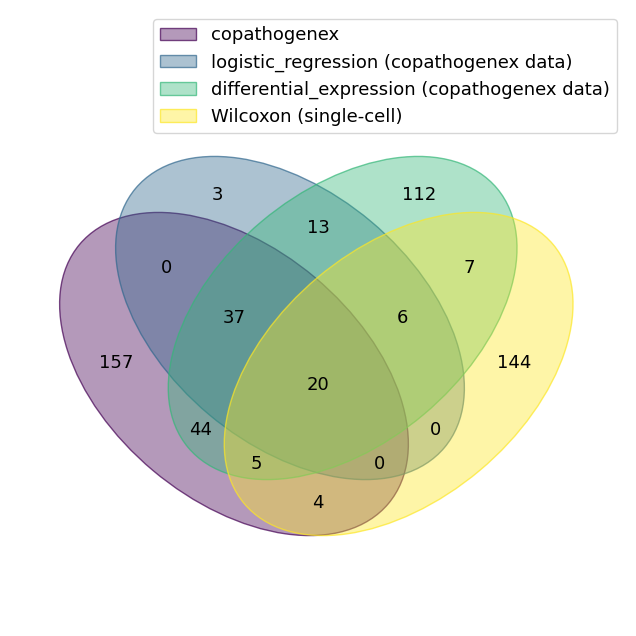

In [24]:
import venn


res_dict = {
    "copathogenex": set(total_compare[total_compare["copathogenex"] == True]["names"].tolist()),
    "logistic_regression (copathogenex data)": set(total_compare[total_compare["logistic_regression"] == True]["names"].tolist()),
    "differential_expression (copathogenex data)": set(total_compare[total_compare["differential_expression"] == True]["names"].tolist()),
    "Wilcoxon (single-cell)": set(total_compare[total_compare["Wilcoxon"] == True]["names"].tolist()),

}
venn.venn(res_dict)
plt.show()

In [26]:
total_compare[
    ((total_compare["copathogenex"] == True) |
    (total_compare["logistic_regression"] == True) |
    (total_compare["differential_expression"] == True)) &
    (total_compare["Wilcoxon"] == True)
    ].loc[:, ["Name", "PGFam", "Wilcoxon_rank"]]

Name  \
PA4514             iron transport outer membrane receptor   
PA4370  insulin-cleaving metalloproteinase outer membr...   
PA4515                                        hydroxylase   
PA5531                                   transporter TonB   
PA4709                             hemin degrading factor   
PA4710  heme/hemoglobin uptake outer membrane receptor...   
PA4516                               hypothetical protein   
PA4707                           ABC transporter permease   
PA0472                        RNA polymerase sigma factor   
PA0672                                     heme oxygenase   
PA2468                              ECF sigma factor FoxI   
PA2426          extracytoplasmic-function sigma-70 factor   
PA4371                               hypothetical protein   
PA4513                                     oxidoreductase   
PA0929                   two-component response regulator   
PA2467                             anti-sigma factor FoxR   
PA4468                               superoxide dismutase   
PA3530                               hypothetical protein   
PA0931                       outer membrane receptor FepA   
PA5217     iron ABC transporter substrate-binding protein   
PA3899                        RNA polymerase sigma factor   
PA4470                                 fumarate hydratase   
PA4708                              heme-transporter PhuT   
PA4227                     transcriptional regulator PchR   
PA1911                        sigma factor regulator FemR   
PA4168             second ferric pyoverdine receptor FpvB   
PA0930                               two-component sensor   
PA1912                              ECF sigma factor FemI   
PA3900                               transmembrane sensor   
PA1300                      ECF subfamily sigma-70 factor   
PA0471                               transmembrane sensor   
PA4706                 hemin importer ATP-binding subunit   
PA2033                               hypothetical protein   
PA1365                               siderophore receptor   
PA4471                               hypothetical protein   
PA4705                               hypothetical protein   
PA1802    ATP-dependent protease ATP-binding subunit ClpX   
PA1301                               transmembrane sensor   
PA4467                               hypothetical protein   
PA0800                               hypothetical protein   
PA4469                               hypothetical protein   
PA5148                               hypothetical protein   

                                                    PGFam  Wilcoxon_rank  
PA4514                                                NaN              1  
PA4370                                                NaN              2  
PA4515                                                NaN              4  
PA5531                                                NaN              6  
PA4709                                                NaN              9  
PA4710                                                NaN             10  
PA4516                                                NaN             11  
PA4707                                                NaN             13  
PA0472               RNA polymerase ECF-type sigma factor             14  
PA0672   Heme oxygenase HemO, associated with heme uptake             16  
PA2468             FIG006045: Sigma factor, ECF subfamily             17  
PA2426  Sigma factor PvdS, controling pyoverdin biosyn...             18  
PA4371                                                NaN             19  
PA4513                                                NaN             20  
PA0929  Two-component transcriptional response regulat...             21  
PA2467                    Iron siderophore sensor protein             24  
PA4468                                                NaN             26  
PA3530                                                NaN             28  
PA09